This notebook is about Principal Component Analysis. 

Importing relevant packages

In [1]:
import os
import matplotlib.pyplot as plt
import geopandas
import pandas as pd
import seaborn as sn
import numpy as np
from pyspatialml import Raster

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

Setting up the directory

In [3]:
os.chdir(r'C:\Users\aageen17\Desktop\Variables')

Loading the data (landslide presence/absebce points)

In [4]:
data=pd.read_csv('sample_points.csv')

In [5]:
data.head()

,dem_elevation,TWI,TPI,TRI,SPI,easterness,northerness,profile_curvature,slope_degrees,slope_std,...,rain_5_year_ref,rain_50_year_ref,rain_average_ref,rain_max_14day_ref,rain_max_day_ref,soil,geomorphology,underground,prequaternary,class
0,15.706318,4.440497,0.126874,0.173688,-1.667908,0.196570,-0.980490,-6.253337,2.642915,4.752529,...,43.898960,66.461922,2.006541,91.624649,33.681606,15.0,7.0,3.0,6.0,1
1,15.232349,3.427183,0.048178,0.395249,0.731700,0.575379,-0.817887,-1.694853,14.511214,3.343206,...,43.898960,66.461922,2.006541,91.624649,33.681606,15.0,7.0,3.0,6.0,1
2,17.030214,3.888671,-0.000931,0.361396,1.081142,0.634705,-0.772755,1.467297,13.748485,0.880331,...,43.898960,66.461922,2.006541,91.624649,33.681606,15.0,7.0,3.0,6.0,1
3,15.583941,4.675134,-0.030232,0.183543,0.294679,-0.788825,-0.614618,-2.029751,6.327752,3.459515,...,44.025265,66.691368,2.017731,91.936996,33.668327,15.0,7.0,3.0,6.0,1
4,17.499943,8.491714,0.150789,0.410609,5.817518,0.268115,-0.963387,-2.833697,14.660413,2.392220,...,44.125858,66.770096,2.021318,92.116493,33.706505,15.0,7.0,3.0,6.0,1


Dropping categorical columns

In [6]:
data = data.drop(columns=['soil', 'geomorphology', 'underground', 'prequaternary'])

Separating features from labels

In [7]:
X = data.iloc[:, 0:-1]

In [8]:
y = data["class"]

Splitting the data into training (70%) and testing (30%)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Standardizing the data before PCA

In [10]:
scaler=StandardScaler().fit(X_train)
standardized_train_data = scaler.transform(X_train)

Creating a PCA model. 16 Principal Components are chosen, because they retain 95% of variance in our data. It reduces the dimensionality of our dataset from 28 to 16 dimensions

In [11]:
pca_model = PCA(n_components=16)
pc_train_data= pca_model.fit_transform(standardized_train_data)


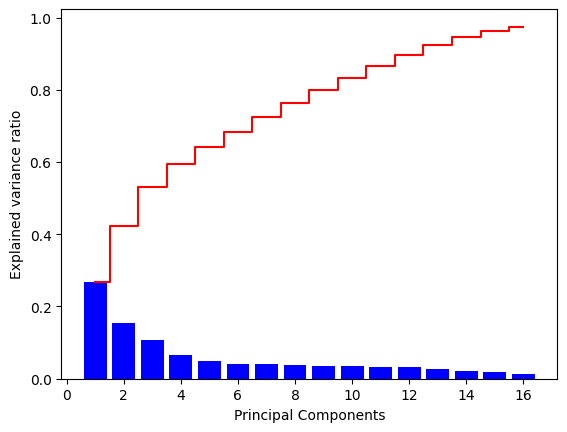

In [12]:
# like we did above visualize the PCs 
# and the cumulative variance explained by each PC

plt.bar(range(1,17), pca_model.explained_variance_ratio_,
        alpha=1,
        align='center',
       color='blue')
plt.step(range(1,17), np.cumsum(pca_model.explained_variance_ratio_),
         where='mid',
         color='red')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal Components')
plt.savefig(r'C:\Users\aageen17\Desktop\figures\variance_pca.png', bbox_inches='tight', dpi=600)
plt.show()

In [13]:
pca_model.explained_variance_ratio_

array([0.26654144, 0.15565742, 0.10819378, 0.0643117 , 0.04782469,
       0.04152041, 0.04013638, 0.03828299, 0.03587923, 0.0339362 ,
       0.03278946, 0.03164242, 0.02627818, 0.02201679, 0.01746979,
       0.01220231])

In [14]:
pca_model.explained_variance_ratio_.cumsum()

array([0.26654144, 0.42219886, 0.53039264, 0.59470434, 0.64252904,
       0.68404945, 0.72418583, 0.76246881, 0.79834804, 0.83228424,
       0.86507371, 0.89671613, 0.92299431, 0.9450111 , 0.96248089,
       0.97468321])

The first component captures around 27% of variability in our data, while the second component - around 15% and so on.
16 Principal Components explain around 97% of the variability in the data

In [15]:
# component loadings or weights (correlation coefficient between original variables and the component) 
# component loadings represent the elements of the eigenvector
# the squared loadings within the PCs always sums to 1
#components_ attribute provides principal axes in feature space,
#representing the directions of maximum variance in the data. 
#This means, we can see influence on each of the components by variables

loadings = pca_model.components_
num_pc = pca_model.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = X.columns
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
variable,,,,,,,,,,,,,,,,
dem_elevation,-0.294540,-0.096963,0.015004,0.250949,0.022454,-0.067461,-0.182212,0.117429,-0.086295,0.004436,0.005248,-0.155762,0.070814,-0.075228,-0.139426,0.256387
TWI,-0.125669,-0.183639,0.298986,-0.098221,0.500030,-0.101042,0.180491,-0.048283,0.019293,-0.015951,0.275345,0.012396,0.053409,0.057138,0.120249,0.063387
TPI,-0.010805,-0.016797,-0.561582,0.055371,0.223522,-0.069219,0.071518,-0.031434,-0.004002,-0.015026,0.126555,0.020988,0.035887,0.009142,-0.032832,-0.007642
TRI,0.173997,0.408682,0.026673,0.180780,-0.027237,-0.091385,-0.006316,0.004007,0.027386,-0.039518,-0.005985,-0.071216,0.093408,-0.178202,-0.081250,-0.005407
SPI,0.055892,0.225912,0.294204,0.035685,0.515496,-0.174404,0.182444,-0.030986,0.018214,-0.086920,0.262137,-0.008733,0.081780,-0.048845,0.123498,0.034248
easterness,0.063146,0.034693,0.024873,0.010785,0.364686,-0.135533,-0.442239,-0.323057,-0.264270,0.543854,-0.377148,0.135115,-0.110290,-0.045036,0.008019,-0.004761
northerness,-0.122517,-0.032054,-0.016084,0.087751,-0.092838,-0.040212,0.481202,-0.338400,-0.498121,-0.058979,-0.327760,-0.346483,0.312016,0.072963,0.171715,-0.071856
profile_curvature,0.016543,0.002153,0.492331,-0.029729,-0.284396,0.087202,-0.129530,0.047727,0.022068,-0.005787,-0.130143,0.028398,-0.043869,-0.161853,0.540003,0.207975
slope_degrees,0.170052,0.413043,0.002316,0.186760,-0.022543,-0.085066,-0.007081,0.010370,0.027384,-0.042012,-0.016439,-0.047928,0.084783,-0.213202,-0.042916,-0.013390


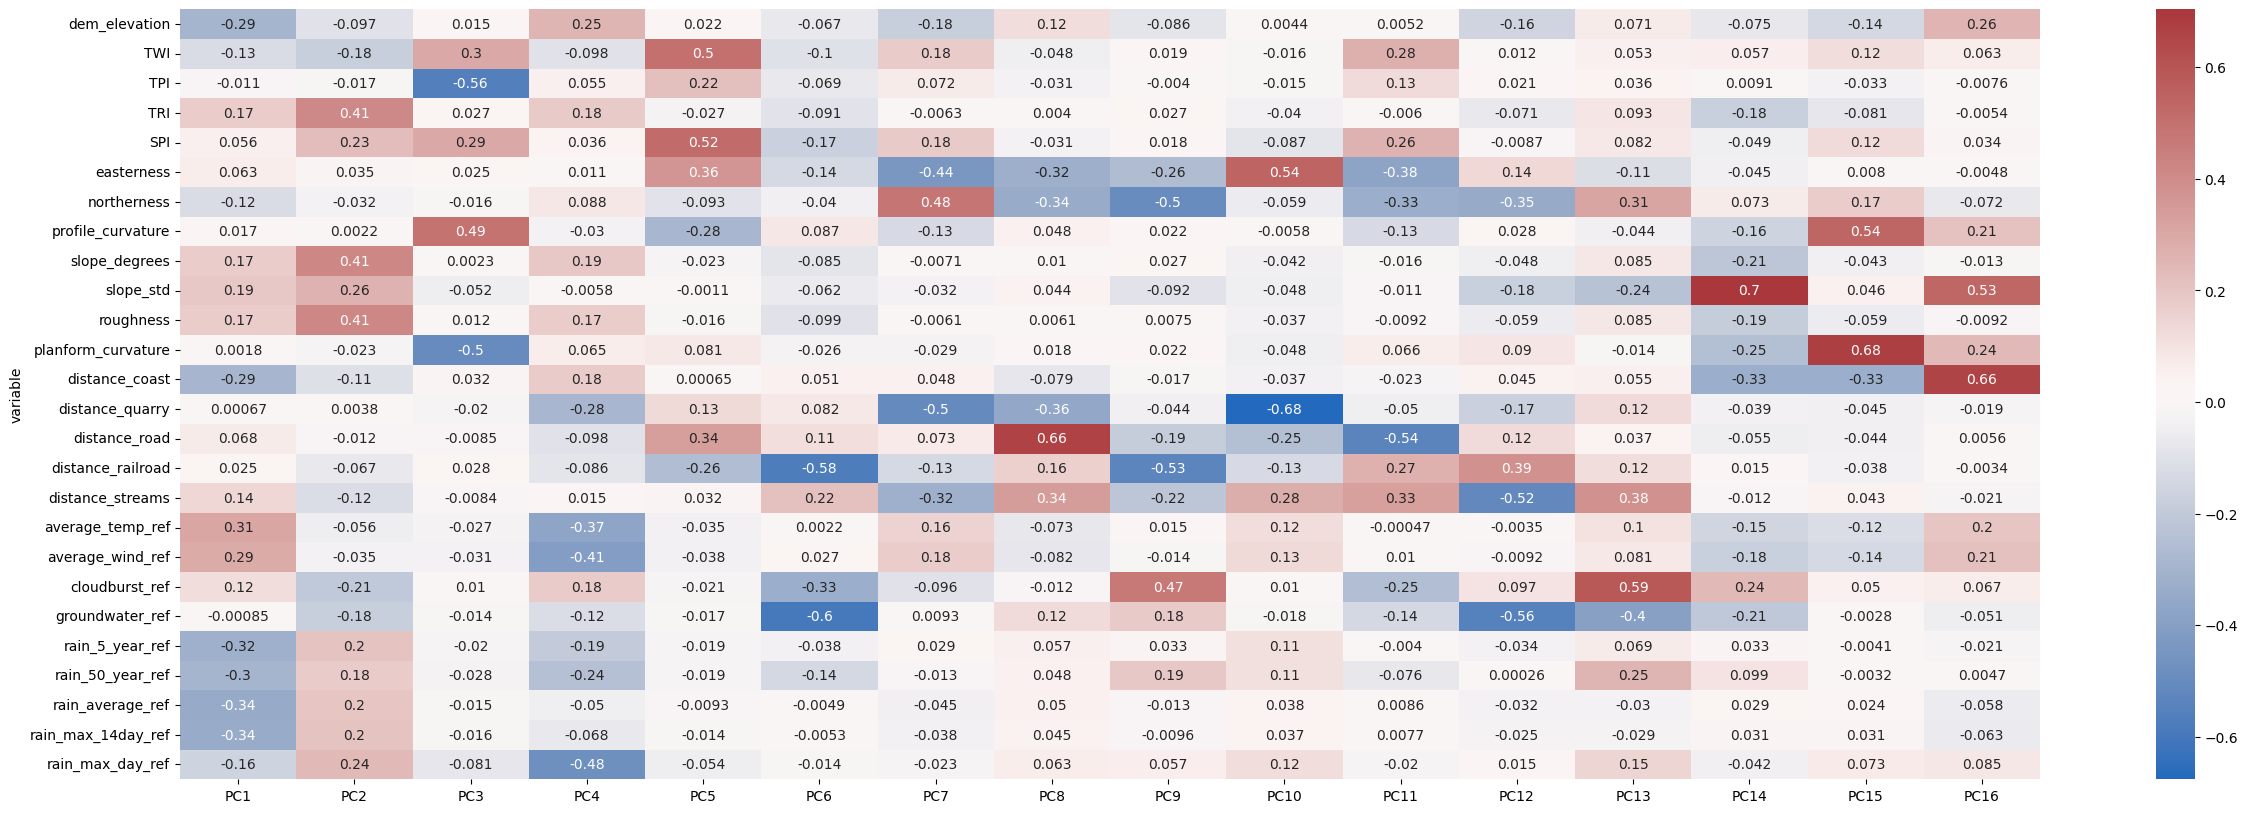

In [16]:
# get correlation matrix plot for loadings
f, ax = plt.subplots(figsize=(30, 10))
ax = sn.heatmap(loadings_df, annot=True, cmap='vlag')
plt.savefig(r'C:\Users\aageen17\Desktop\figures\loadings_tal_pca.png', bbox_inches='tight', dpi=600)
plt.show()

A different way of plotting it

In [17]:
f, ax = plt.subplots(figsize=(20, 10))
ax = sn.heatmap(pca_model.components_,
                 cmap='vlag',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pca_model.n_components_+1)],
                 xticklabels=list(X.columns),
                 cbar_kws={"orientation": "vertical"})
#plt.savefig(r'C:\Users\aageen17\Desktop\figures\loadings_pca.png', bbox_inches='tight')
#ax.set_aspect("equal")



Bioplot contains PCA loading plot which shows how much each variables effects a principal component.

PCA Loading Plot: All vectors start at origin and their projected values on components explains how much influence they have on that component. Angles between vectors indicate whether there is correlation between them - smaller angles tell about stronger correlation.

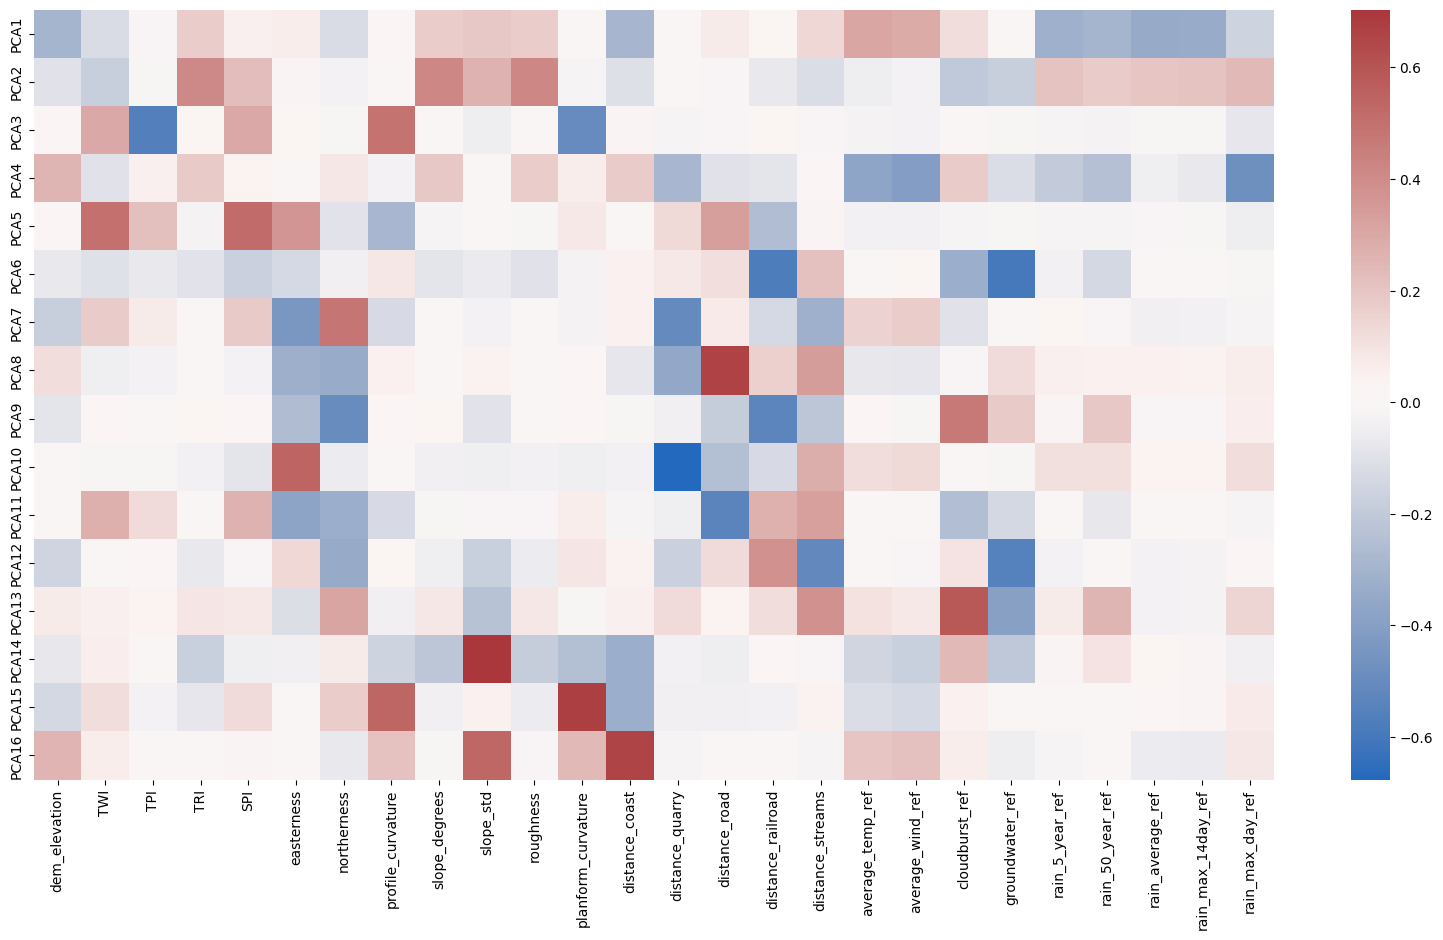

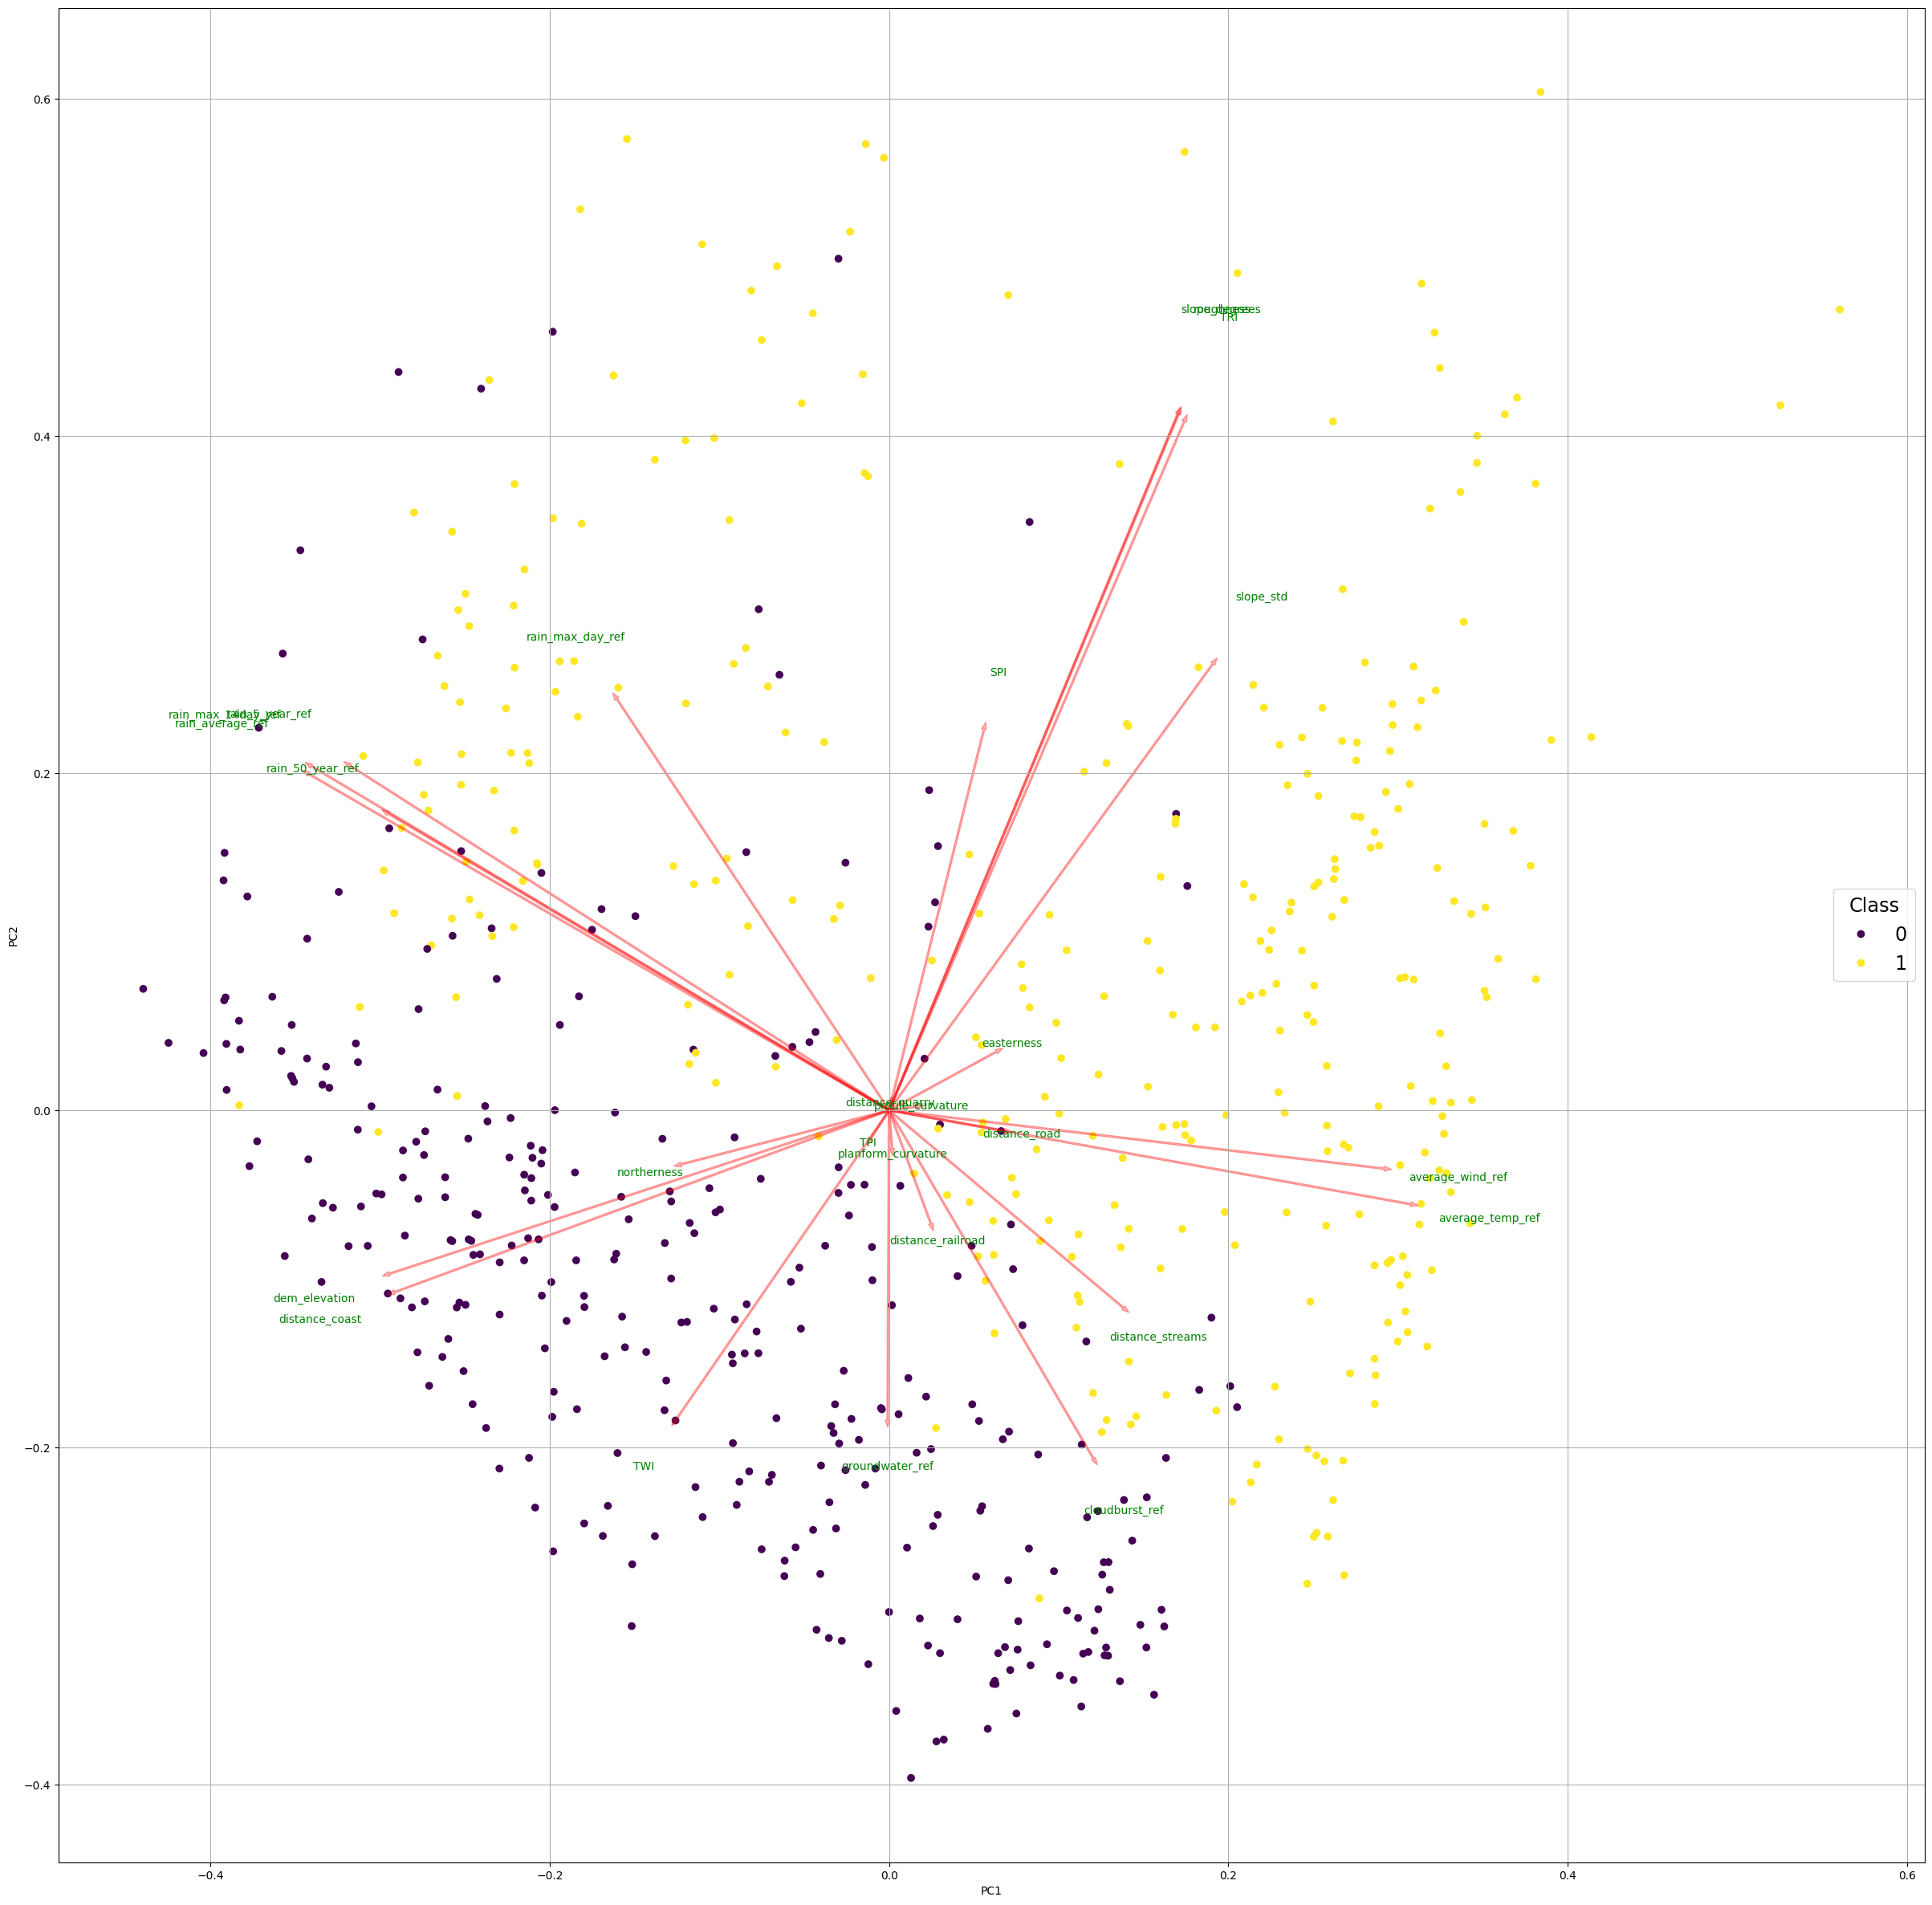

In [18]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    scatter = plt.scatter(xs * scalex,ys * scaley, c=y_train)
    
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.3)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    labels = np.unique(y)
    handles = [plt.Line2D([],[],marker="o", ls="", 
                      color=scatter.cmap(scatter.norm(yi))) for yi in labels]
    plt.legend(handles, labels, loc=7, title='Class', title_fontsize='xx-large', fontsize='xx-large')
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    

    
f, ax = plt.subplots(figsize=(30,30))
myplot(pc_train_data[:,0:2],np.transpose(pca_model.components_[0:2, :]),list(X.columns))
plt.savefig(r'C:\Users\aageen17\Desktop\figures\loadings_plot_pca.png', bbox_inches='tight', dpi=600)
plt.show()


Transforming testing data

In [19]:
standardized_test_data=scaler.transform(X_test)

In [20]:
pc_test_data=pca_model.transform(standardized_test_data)

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

The resulted Principal Components can be used for Machine Learning instead of the original data. The results below are though not represented in the project, as PCA was mainly used for understanding the data. 

## Random Forest

In [24]:
# Number of trees in random forest 
n_estimators = [100, 200, 300, 500, 700, 1000, 1200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

In [25]:
# Create the  grid
grid_rf = {'n_estimators': n_estimators,
               'max_features': max_features}
print(grid_rf)

{'n_estimators': [100, 200, 300, 500, 700, 1000, 1200], 'max_features': ['auto', 'sqrt', 'log2']}


In [27]:
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf, param_grid = grid_rf, cv = 10)


In [28]:
grid_search_rf.fit(pc_train_data, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 500, 700, 1000, 1200]})

In [29]:
grid_search_rf.best_params_

{'max_features': 'sqrt', 'n_estimators': 100}

Creating the final RF classifier with the best hyperparameters

In [30]:
scaler = StandardScaler()
pca = PCA(n_components = 16)
# set the tolerance to a large value to make the example faster
rf = RandomForestClassifier(random_state=42, max_features= 'sqrt', n_estimators=100)
pipeline_rf = Pipeline([('scaler', scaler), ('dims_reduction', pca), ('classifier', rf)])

In [31]:
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('dims_reduction', PCA(n_components=16)),
                ('classifier',
                 RandomForestClassifier(max_features='sqrt', random_state=42))])

Creating an evaluation function

In [32]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, accuracy_score, confusion_matrix
from sklearn.metrics import cohen_kappa_score

def evaluate(model, test_features, test_labels):
    y_pred = model.predict(test_features)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print (accuracy)
    print(confusion_matrix(y_test,y_pred))
    print(cohen_kappa_score(y_test, y_pred))

In [33]:
evaluate(pipeline_rf, X_test, y_test)

0.9080882352941176
[[122  14]
 [ 11 125]]
0.8161764705882353


## Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
lr = LogisticRegression() 

In [36]:
param_grid_lr = [
  {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['liblinear'], 'penalty': ['l1','l2']},
  {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs'], 'penalty': ['l2']},
 ]

In [37]:
# Instantiate the grid search model
grid_search_LR = GridSearchCV(estimator = lr, param_grid = param_grid_lr, 
                          cv = 10, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search_LR.fit(pc_train_data ,y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
                         {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'penalty': ['l2'], 'solver': ['lbfgs']}],
             verbose=2)

In [38]:
grid_search_LR.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

Creating the final LR classifier with the best hyperparameters

In [39]:
scaler = StandardScaler()
pca = PCA(n_components = 16)
# set the tolerance to a large value to make the example faster
lr = LogisticRegression(random_state=42, C=0.1, penalty='l2', solver='liblinear')
pipeline_lr = Pipeline([('scaler', scaler), ('dims_reduction', pca), ('classifier', lr)])

In [40]:
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('dims_reduction', PCA(n_components=16)),
                ('classifier',
                 LogisticRegression(C=0.1, random_state=42,
                                    solver='liblinear'))])

In [41]:
evaluate(pipeline_lr,X_test,y_test)

0.8933823529411765
[[122  14]
 [ 15 121]]
0.7867647058823529


## Support Vector Machine

In [42]:
from sklearn.svm import SVC

Parameters for  grid search

In [43]:
param_grid_SVM = [
  {'C': [0.001, 0.1, 1, 10], 'kernel': ['linear']},
  {'C': [0.001, 0.1, 1, 10], 'gamma': [1, 0.1, 0.01,0.001, 0.0001], 'kernel': ['rbf', 'poly', 'sigmoid']},
 ]


In [44]:
# Create a based model
svm = SVC(random_state=42)
# Instantiate the grid search model
grid_search_SVM = GridSearchCV(estimator = svm, param_grid = param_grid_SVM, 
                          cv = 10, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search_SVM.fit(pc_train_data,y_train)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


GridSearchCV(cv=10, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.1, 1, 10], 'kernel': ['linear']},
                         {'C': [0.001, 0.1, 1, 10],
                          'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['rbf', 'poly', 'sigmoid']}],
             verbose=2)

In [45]:
grid_search_SVM.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'sigmoid'}

Creating the final SVM classifier with the best hyperparameters

In [46]:
scaler = StandardScaler()
pca = PCA(n_components = 16)
svm = SVC(random_state=42, C=10, gamma=0.01, kernel='sigmoid', probability=True)
pipeline_svm = Pipeline([('scaler', scaler), ('dims_reduction', pca), ('classifier', svm)])

In [47]:
pipeline_svm.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('dims_reduction', PCA(n_components=16)),
                ('classifier',
                 SVC(C=10, gamma=0.01, kernel='sigmoid', probability=True,
                     random_state=42))])

In [48]:
evaluate(pipeline_svm, X_test ,y_test)

0.9044117647058824
[[119  17]
 [  9 127]]
0.8088235294117647
